In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses
from tensorflow.keras.datasets import mnist

In [2]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
# Based on https://medium.com/@weidagang/demystifying-neural-networks-variational-autoencoders-6a44e75d0271#:~:text=A%20variational%20autoencoder%20is%20a,into%20a%20compact%2C%20latent%20representation.
# Updated to latest tensorflow keras API with ChatGPT
class VAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        """
        Initializes the VAE model with an encoder and decoder.

        :param input_dim: The number of input features.
        :param latent_dim: The dimensionality of the latent space.
        """
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Build the encoder
        self.encoder = self.build_encoder()

        # Build the decoder
        self.decoder = self.build_decoder()

    def build_encoder(self):
        """Builds the encoder model."""
        encoder_inputs = layers.Input(shape=(self.input_dim,))
        
        # First dense layer
        x = layers.Dense(512, activation='relu')(encoder_inputs)

        # Add additional layer if input_dim > 512
        if self.input_dim > 512:
            x = layers.Dense(256, activation='relu')(x)

        if self.input_dim > 1024:  # Further compression for even larger inputs
            x = layers.Dense(128, activation='relu')(x)

        # Latent space parameters
        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)

        # Reparameterization trick
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
            return z_mean + tf.exp(z_log_var / 2) * epsilon

        z = layers.Lambda(sampling)([z_mean, z_log_var])  # Lambda layer to handle the sampling trick
        encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

        return encoder

    def build_decoder(self):
        """Builds the decoder model."""
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        
        # First dense layer to start decoding
        x = layers.Dense(256, activation='relu')(latent_inputs)

        # Add additional layer if input_dim > 512
        if self.input_dim > 512:
            x = layers.Dense(512, activation='relu')(x)

        if self.input_dim > 1024:  # Expand further for larger inputs
            x = layers.Dense(1024, activation='relu')(x)

        # Final output layer
        decoder_outputs = layers.Dense(self.input_dim, activation='sigmoid')(x)
        decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

        return decoder

    def call(self, inputs):
        """Forward pass through the VAE."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.keras.losses.mse(inputs, reconstructed)
        reconstruction_loss *= self.input_dim  # Rescale due to input shape

        # KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        # Total loss
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return reconstructed

In [4]:
# Example of creating and compiling a VAE model
input_dim = 784  # Number of features (e.g., for MNIST images, this would be 28x28)
latent_dim = 2  # Dimension of the latent space

vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
vae.compile(optimizer='adam')

2025-02-24 13:50:43.561398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 13:50:48.655988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30982 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [5]:
# Train the VAE
vae.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 9s 2ms/step - loss: 43.9722 - val_loss: 40.6210
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 39.4047 - val_loss: 38.6511
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 38.1666 - val_loss: 37.6696
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 37.4519 - val_loss: 37.0966
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 36.8601 - val_loss: 36.6428
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 36.3842 - val_loss: 36.1197
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 36.0001 - val_loss: 35.6873
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 35.7403 - val_loss: 35.7166
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 35.4872 - val_loss: 35.4142
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/

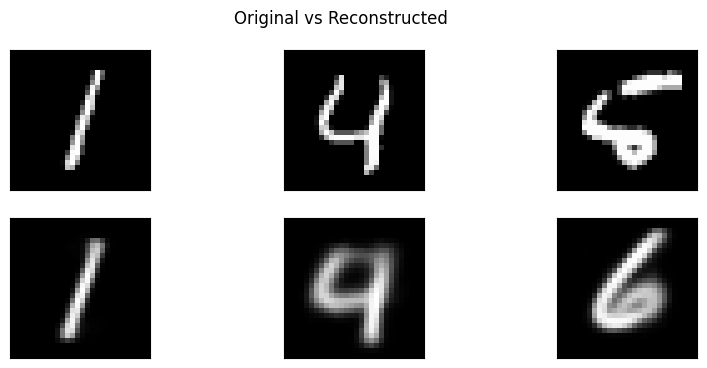

In [11]:
# Test and Visualization
n_to_visualize = 3
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n_to_visualize))  # Two rows for original and reconstructed

# Choose specific test images
test_image_indices = [2, 4, 8]  # Feel free to change these indices
images = x_test[test_image_indices]

# Generate reconstructions
_, _, encoded_images = vae.encoder.predict(images)
decoded_images = vae.decoder.predict(encoded_images)

for i, idx in enumerate(test_image_indices):
    # Original image
    figure[0:digit_size, i * digit_size:(i + 1) * digit_size] = images[i].reshape(28, 28)

    # Reconstructed image
    figure[digit_size:, i * digit_size:(i + 1) * digit_size] = decoded_images[i].reshape(28, 28)

plt.figure(figsize=(10, 4))  # Adjust figure size
plt.suptitle('Original vs Reconstructed')  # Add a title
for i in range(n_to_visualize):
    plt.subplot(2, n_to_visualize, i + 1)
    plt.imshow(figure[0:digit_size, i * digit_size:(i + 1) * digit_size], cmap='gray')
    plt.xticks([])  # Remove ticks
    plt.yticks([])

    plt.subplot(2, n_to_visualize, n_to_visualize + i + 1)  # Subplot for reconstruction
    plt.imshow(figure[digit_size:, i * digit_size:(i + 1) * digit_size], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [12]:
# Encode the test set images to get the latent variables (z_mean, z_log_var)
z_mean, _, _ = vae.encoder.predict(x_test)

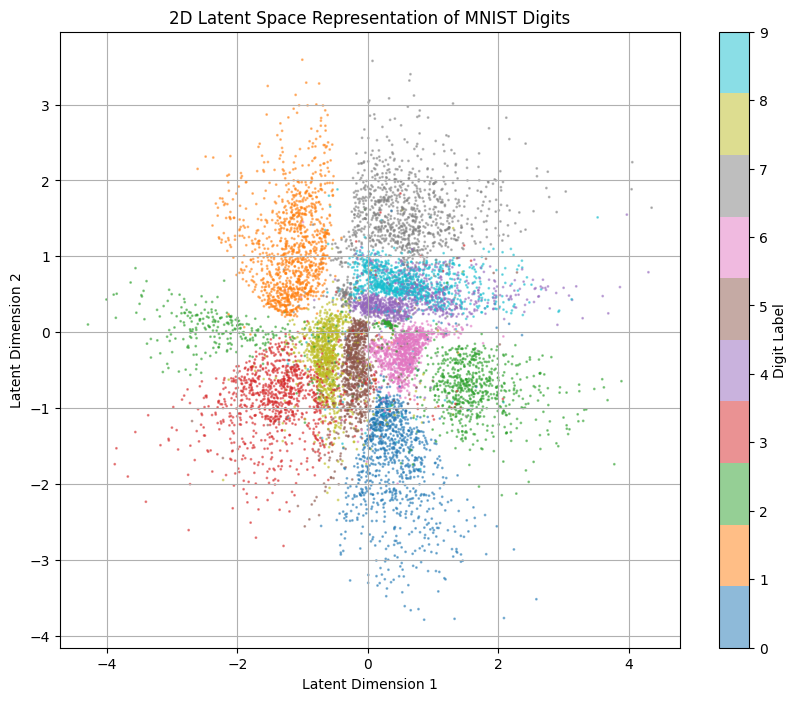

In [13]:
# Define a discrete color palette with 10 distinct colors
from matplotlib import colors
digit_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
cmap = colors.ListedColormap(digit_colors)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=cmap, alpha=0.5, s=1)
# Create a colorbar with the 10 digit labels
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Digit Label')
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))  # Label the colorbar with digit values

plt.title('2D Latent Space Representation of MNIST Digits')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

In [9]:
# import umap
# from sklearn.manifold import TSNE

# # Assuming z_mean (latent variables) and y_test (digit labels) are already available

# # UMAP
# umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
# umap_embeddings = umap_reducer.fit_transform(z_mean)

# # t-SNE
# tsne_reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
# tsne_embeddings = tsne_reducer.fit_transform(z_mean)

# # Create plots
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# # Plot UMAP results
# scatter_umap = axs[0].scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, cmap='tab10', alpha=0.8)
# axs[0].set_title('UMAP Projection of Latent Space')
# axs[0].set_xlabel('UMAP Dimension 1')
# axs[0].set_ylabel('UMAP Dimension 2')
# cbar_umap = plt.colorbar(scatter_umap, ax=axs[0], ticks=range(10))
# cbar_umap.set_label('Digit Label')

# # Plot t-SNE results
# scatter_tsne = axs[1].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_test, cmap='tab10', alpha=0.8)
# axs[1].set_title('t-SNE Projection of Latent Space')
# axs[1].set_xlabel('t-SNE Dimension 1')
# axs[1].set_ylabel('t-SNE Dimension 2')
# cbar_tsne = plt.colorbar(scatter_tsne, ax=axs[1], ticks=range(10))
# cbar_tsne.set_label('Digit Label')

# plt.tight_layout()
# plt.show()


In [14]:
X = np.load("X.npy")

In [ ]:
# Check for columns with all zeros
columns_with_all_zeros = np.all(X == 0, axis=0)

# Get the indices of the columns that are all zeros
zero_columns_indices = np.where(columns_with_all_zeros)[0]

print("Indices of columns with all zeros:", zero_columns_indices)

In [ ]:
# Check for rows with all zeros
rows_with_all_zeros = np.all(X == 0, axis=1)

# Get the indices of the rows that are all zeros
zero_rows_indices = np.where(rows_with_all_zeros)[0]

print("Indices of rows with all zeros:", zero_rows_indices)

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# X = StandardScaler().fit_transform(np.log2(X + .01))
# X[X < 1.64] = 0.0
# X[X >= 1.64] = 1.0

In [14]:
input_dim = X.shape[1]
latent_dim = 32
avae = VAE(input_dim=input_dim, latent_dim=latent_dim)
vae.compile(optimizer='adam')

NameError: name 'X' is not defined

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(X, test_size=.1)
print(x_train.shape, x_test.shape)

(834158, 465) (92685, 465)


In [24]:
# Compile and train the VAE model
history = vae.fit(x_train, x_train, epochs=10, batch_size=32, validation_data = [x_test])

Epoch 1/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - loss: 12.4229 - val_loss: 10.0824
Epoch 2/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 10.0144 - val_loss: 9.9928
Epoch 3/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.9158 - val_loss: 9.8758
Epoch 4/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.9006 - val_loss: 9.9769
Epoch 5/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.8303 - val_loss: 9.8910
Epoch 6/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.8259 - val_loss: 9.9033
Epoch 7/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.8284 - val_loss: 9.8292
Epoch 8/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.7859 - val_loss: 9.8025
Epoch 9/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.8028 - val_loss: 9.8967
Epoch 10/10
26068/26068 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 9.7730 - val_loss: 9.9861


In [25]:
z_mean, _, _ = vae.encoder.predict(X)

28964/28964 ━━━━━━━━━━━━━━━━━━━━ 22s 734us/step


In [26]:
np.save("z_mean.npy", z_mean)

In [27]:
from sklearn.decomposition import PCA
pca = PCA().fit_transform(z_mean)

In [28]:
import pandas as pd
cCREs = pd.read_csv("mm10-cCREs.bed", sep="\t", header=None, names=["chrom", "start", "end", "rDHS", "cCRE", "type"])
cCREs.head()

,chrom,start,end,rDHS,cCRE,type
0,chr1,3012681,3012836,EM10D1036230,EM10E0932225,CA-CTCF
1,chr1,3035821,3035995,EM10D1036232,EM10E1235196,CA
2,chr1,3059627,3059790,EM10D1036235,EM10E1235197,CA
3,chr1,3062547,3062749,EM10D1036236,EM10E1235198,CA
4,chr1,3062789,3063138,EM10D1036237,EM10E1235199,CA


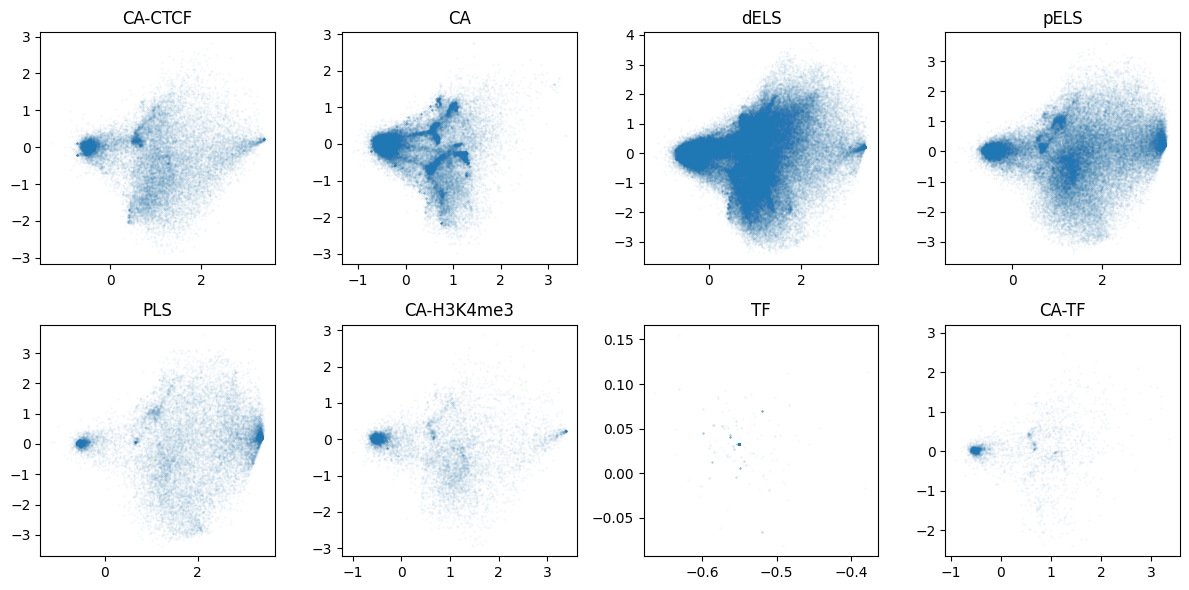

In [31]:
cCRE_types = cCREs.type.unique().tolist()
fig, axes = plt.subplots(2,4, figsize=(12,6), tight_layout=True)
for i, cCRE_type in enumerate(cCRE_types):
    ax = axes.flatten()[i]
    indices = cCREs[cCREs["type"] == cCRE_type].index
    ax.scatter(pca[indices, 0], pca[indices, 1], s=.1, alpha=0.1)
    ax.set_title(cCRE_type)

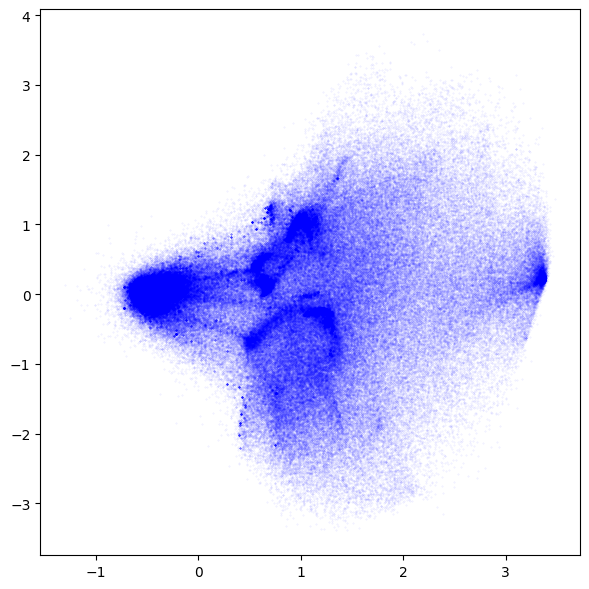

In [36]:
fig, ax = plt.subplots(figsize=(6,6), tight_layout=True)
ax.scatter(pca[:,0], pca[:,1], s=.1, alpha=0.1, c="blue")